In [12]:
import os, json, csv
from shapely import wkt
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [13]:
def convert_tiff_to_jpg_satellite(
    input_tif_path, 
    output_jpg_path, 
    band_order=(1, 2, 3),
    min_percent=2,    # Lower cut for stretch
    max_percent=98    # Upper cut for stretch
):
    """
    Convert a multi-band satellite TIFF to an 8-bit RGB JPEG.
    - band_order: Which bands to use for R, G, B (1-based).
    - min_percent, max_percent: The percentile cuts for min/max stretching.
    
    If your satellite data is 4+ bands (e.g., RGBA or R, G, B, NIR),
    you can specify which 3 to pick for R, G, B. 
    e.g. band_order=(3, 2, 1) might give you a natural color 
    if your GeoTIFF is B, G, R, NIR in that order.
    """

    with rasterio.open(input_tif_path) as src:
        # Read the specified bands into numpy arrays
        arrs = [src.read(b).astype(np.float32) for b in band_order]
        # Stack into shape (height, width, 3)
        rgb = np.dstack(arrs)
        
        # Optionally stretch the data for display
        # 1) Flatten to get global stats across all 3 channels
        flat = rgb.flatten()
        # Remove NaN or no-data (if any)
        flat = flat[~np.isnan(flat)]
        
        # 2) Compute chosen percentile range
        min_val = np.percentile(flat, min_percent)
        max_val = np.percentile(flat, max_percent)

        # 3) Clip, then scale to [0..255]
        rgb = np.clip(rgb, min_val, max_val)
        rgb = ( (rgb - min_val) / (max_val - min_val + 1e-6) ) * 255.0
        
        # Convert to uint8
        rgb_8 = rgb.astype(np.uint8)
        
        # Save to JPEG using Pillow
        img = Image.fromarray(rgb_8, mode='RGB')
        img.save(output_jpg_path, 'JPEG')

        print(f"Saved {output_jpg_path}")

def batch_tiff_to_jpg_satellite(
    input_dir, 
    output_dir, 
    band_order=(1, 2, 3)
):
    """
    Loop over a directory of TIFFs and convert each to JPEG,
    picking the desired band_order and using default stretch params.
    """
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if fname.lower().endswith(('.tif', '.tiff')):
            in_path = os.path.join(input_dir, fname)
            base = os.path.splitext(fname)[0]
            out_path = os.path.join(output_dir, f"{base}.jpg")
            convert_tiff_to_jpg_satellite(
                in_path, out_path, band_order=band_order
            )

In [14]:
def json_to_bboxes(input_json_dir, output_csv_dir):
    """
    For each JSON in input_json_dir, parse the bounding boxes from
    the polygon WKT. Output a CSV with (feature_type, x_min, y_min, x_max, y_max).
    """
    os.makedirs(output_csv_dir, exist_ok=True)
    
    for filename in os.listdir(input_json_dir):
        if filename.lower().endswith('.json'):
            input_path = os.path.join(input_json_dir, filename)

            # Read JSON
            with open(input_path, 'r') as f:
                data = json.load(f)
            
            # The “xy” key in features holds the polygon data
            if "features" not in data or "xy" not in data["features"]:
                # If no polygons, skip or write an empty CSV
                print(f"No 'xy' found in {filename}. Skipping or creating empty CSV.")
                continue
            
            # Prepare output CSV
            base_name = os.path.splitext(filename)[0]
            output_csv_path = os.path.join(output_csv_dir, f"{base_name}.csv")
            
            with open(output_csv_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["feature_type", "x_min", "y_min", "x_max", "y_max"])
                
                # Iterate over polygons
                for poly_info in data["features"]["xy"]:
                    # Read the feature_type
                    feature_type = poly_info["properties"]["feature_type"]
                    
                    # Parse the WKT
                    polygon = wkt.loads(poly_info["wkt"])
                    
                    # Get the bounding box (minx, miny, maxx, maxy)
                    minx, miny, maxx, maxy = polygon.bounds
                    
                    # Write row to CSV
                    writer.writerow([
                        feature_type,
                        f"{minx:.3f}",
                        f"{miny:.3f}",
                        f"{maxx:.3f}",
                        f"{maxy:.3f}"
                    ])
            
            print(f"Created CSV: {output_csv_path}")


In [15]:
def display_image_with_bboxes(image_path, csv_path):
    """
    Show the image at image_path, then read the bounding boxes from csv_path
    and draw them on top of the image.
    """
    # Open the image
    img = Image.open(image_path)
    
    # Create a matplotlib figure
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    # Read bounding boxes
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            feature_type = row["feature_type"]
            x_min = float(row["x_min"])
            y_min = float(row["y_min"])
            x_max = float(row["x_max"])
            y_max = float(row["y_max"])
            
            # Width and height of the bounding box
            width = x_max - x_min
            height = y_max - y_min
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            
            ax.add_patch(rect)
            
            # (Optional) Add text label
            #ax.text(
            #    x_min, y_min - 2,
            #    feature_type,
            #    color='red',
            #    fontsize=10,
            #    backgroundcolor='white'
            #)
    
    plt.title(f"Image with bounding boxes\n{image_path}")
    plt.axis('off')
    plt.show()

# Usage:
# display_image_with_bboxes(
#     image_path='/path/to/your.jpg',
#     csv_path='/path/to/your.csv'
# )


In [16]:
## must process each partition; add train/valid/test for modeling
input_images_path = "sample_input/xview_images"
input_labels_path = "sample_input/buildings_labels"
output_images_path = "sample_output/jpeg_images"
output_labels_path = "sample_output/bbox_csv"

batch_tiff_to_jpg_satellite(
    input_dir=input_images_path,
    output_dir=output_images_path,
    band_order=(1, 2, 3)
)

json_to_bboxes(
    input_json_dir=input_labels_path,
    output_csv_dir=output_labels_path
)

Saved sample_output/jpeg_images\guatemala-volcano_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\hurricane-florence_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\hurricane-harvey_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\hurricane-matthew_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\hurricane-michael_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\joplin-tornado_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\lower-puna-volcano_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\mexico-earthquake_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\moore-tornado_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\nepal-flooding_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\palu-tsunami_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\pinery-bushfire_00000000_pre_disaster.jpg
Saved sample_output/jpeg_images\portugal-wildfire_00000000_pre_disaster.jpg
Saved sample_output/jpeg_ima

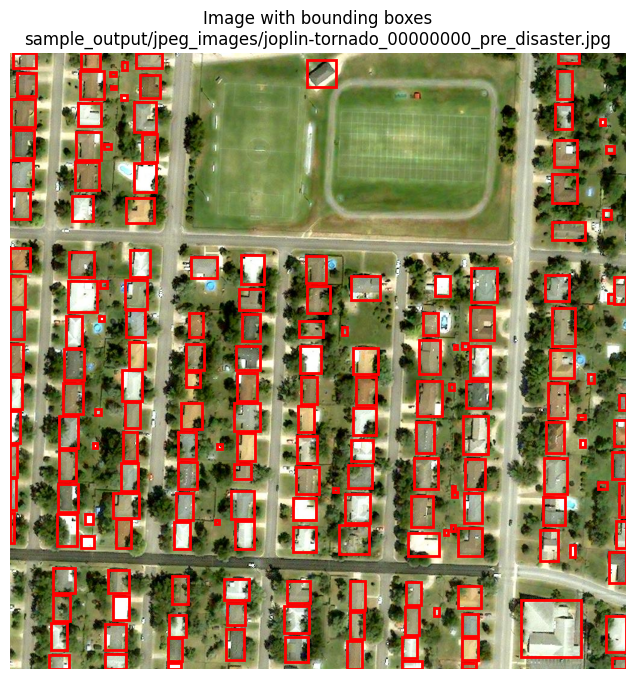

In [20]:
display_image_with_bboxes(
    image_path=output_images_path + "/joplin-tornado_00000000_pre_disaster.jpg",
    csv_path=output_labels_path + "/joplin-tornado_00000000_pre_disaster.csv"
)